In [1]:
# import general classes for data processing
import ruptures as rpt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder

# import our custom classes
import sys
path_to_directory = '../'
if path_to_directory not in sys.path:
    sys.path.append(path_to_directory)
from model import Signal, GestureRecognitionModel
from model import GestureRecognitionDataset

# import SVM classes
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.preprocessing import StandardScaler

# import MLP
from sklearn.neural_network import MLPClassifier

# import for loop and XGboost
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

# import ensemble function and random forest
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

# import model saving
import joblib

# kappa score
from sklearn.metrics import cohen_kappa_score

In [8]:
df = pd.read_csv('../data_rem.csv')

subjects = list(df.subject.unique())
subjects.remove("Mario")
subjects.remove("Hanaa")
subjects.remove("Alex")
subjects.remove("David")
subjects.remove("Francisco")

df = df[df['subject'].isin(subjects)]
subjects

['Aarushi', 'Ester', 'Imen', 'Lluis', 'Sergi', 'Sergio']

0it [00:00, ?it/s]

The accuracy of the model is 80.29%
The accuracy of the model is 78.90%
The accuracy of the model is 77.57%
The accuracy of the model is 59.02%
The accuracy of the model is 57.53%
The accuracy of the model is 62.43%
The accuracy of the model is 67.13%
The accuracy of the model is 76.58%
The accuracy of the model is 63.24%
The accuracy of the model is 83.52%
The accuracy of the model is 79.52%
The accuracy of the model is 74.54%
The accuracy of the model is 65.30%
The accuracy of the model is 67.64%
The accuracy of the model is 57.53%
The accuracy of the model is 56.45%
The accuracy of the model is 67.12%
The accuracy of the model is 73.83%


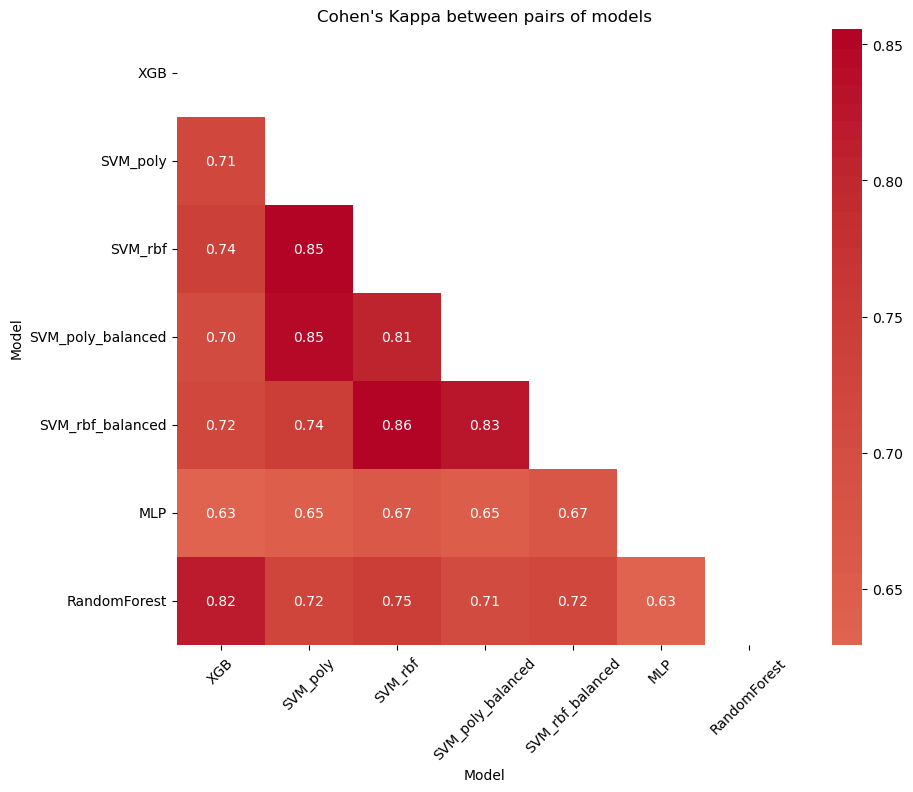

In [9]:
kappa_matrices = []
train_sets = [1, 2, 3]

xgboost_accuracies = [[0 for _ in range(len(train_sets))] for _ in range(len(subjects))]

for subject_idx, person_test in  tqdm(enumerate(subjects)):       
    for train_idx, Take_to_test in enumerate(train_sets):

        df2 = df[(df['subject'] == person_test)]
        model = XGBClassifier()
        clf1 = XGBClassifier()
        clf2 = SVC(kernel="poly", degree=2, C=10)
        clf3 = SVC(kernel="rbf", C=10)
        clf4 = SVC(kernel="poly", degree=2, C=10, class_weight='balanced')
        clf5 = SVC(kernel="rbf", C=10, class_weight='balanced')
        clf6 = MLPClassifier(random_state=1, hidden_layer_sizes=50, max_iter=500)
        clf7 = RandomForestClassifier(random_state=1)

        model = VotingClassifier(estimators=[
            ('xgb', clf1), ('poly', clf2), ('rbf', clf3), ('polycorr', clf4),
            ('rbfcorr', clf5), ('RF', clf7)], voting='hard')

        selected_columns = ['mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7',
                            'rms_0', 'rms_1', 'rms_2', 'rms_3', 'rms_4', 'rms_5', 'rms_6', 'rms_7',
                            'ssc_0', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7',
                            'wl_0', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'var_0',
                            'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'iasd_0',
                            'iasd_1', 'iasd_2', 'iasd_3', 'iasd_4', 'iasd_5', 'iasd_6', 'iasd_7',
                            'iatd_0', 'iatd_1', 'iatd_2', 'iatd_3', 'iatd_4', 'iatd_5', 'iatd_6',
                            'iatd_7']

        df_train = df2[(df2['take'] != Take_to_test)]
        df_test = df2[(df2['take'] == Take_to_test)]

        X_train = df_train[selected_columns]
        y_train = df_train['gesture']
        X_test = df_test[selected_columns]
        y_test = df_test['gesture']

        label_encoder = LabelEncoder()
        Y_encoded = label_encoder.fit_transform(y_train)
        y_train = Y_encoded

        Y_encoded2 = label_encoder.fit_transform(y_test)
        y_test = Y_encoded2

        clf1.fit(X_train, y_train)

        # fitting each remaining classifier on the training data
        for clf in [clf2, clf3, clf4, clf5, clf6, clf7]:
            clf.fit(X_train, y_train)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        predictions = [round(value) for value in y_pred]
        predicted_labels_decoded = label_encoder.inverse_transform(predictions)

        accuracy = accuracy_score(y_test, predictions) * 100
        print("The accuracy of the model is %.2f%%" % accuracy)

        # calculate Cohen's Kappa between pairs of models
        all_predictions = []
        for clf in [clf1, clf2, clf3, clf4, clf5, clf6, clf7]:
            y_pred = clf.predict(X_test)
            all_predictions.append(y_pred)

        model_names = ['XGB', 'SVM_poly', 'SVM_rbf', 'SVM_poly_balanced', 'SVM_rbf_balanced', 'MLP', 'RandomForest']

        kappa_matrix = np.zeros((len(all_predictions), len(all_predictions)))
        for i in range(len(all_predictions)):
            for j in range(i + 1, len(all_predictions)):
                kappa = cohen_kappa_score(all_predictions[i], all_predictions[j])
                kappa_matrix[i, j] = kappa
                kappa_matrix[j, i] = kappa  

        kappa_matrices.append(kappa_matrix)

kappa_matrices1 = np.array(kappa_matrices)
average_matrix = np.mean(kappa_matrices1, axis=0)
mask = np.triu(np.ones_like(average_matrix, dtype=bool))

cmap = sns.diverging_palette(100, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)

plt.figure(figsize=(10,8))
sns.heatmap(average_matrix, mask=mask, center=0, annot=True,
            fmt='.2f', square=True,cmap='coolwarm', xticklabels=model_names, yticklabels=model_names)
plt.title("Cohen's Kappa between pairs of models")
plt.xlabel("Model")
plt.ylabel("Model")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
